In [42]:
def mega_function(username, playlist_uri):

    #libraries
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials
    import spotipy.util as util
    import json
    import numpy as np
    import pandas as pd

    import matplotlib.pyplot as plt
    import seaborn as sns
    import seaborn as sb
    %matplotlib inline
    import plotly.express as px

    import plotly.figure_factory as ff

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import NearestNeighbors
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import GridSearchCV
    from yellowbrick.cluster import KElbowVisualizer
    from sklearn.cluster import KMeans
    from sklearn.datasets import make_blobs
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.spatial.transform import Rotation as R
    import scipy.cluster.hierarchy as shc
    from scipy.spatial import KDTree
    from sklearn.preprocessing import MinMaxScaler

    import statsmodels.api as sm
    from scipy import stats
    from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
    from IPython.display import display, Image, SVG, Math, YouTubeVideo
    
    #Spotify API
    username = 'britopereiraa'
    client_id ='17a3ed14ab434b33b28f19f8bea3337d'
    client_secret = '7f848f9d2a024b15be5fa776b4dc7a05'
    redirect_uri = 'http://localhost:7777/callback'
    scope = 'user-read-recently-played'

    token = util.prompt_for_user_token(username=username, 
                                       scope=scope, 
                                       client_id=client_id,   
                                       client_secret=client_secret,     
                                       redirect_uri=redirect_uri)

    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    
    def master_function(username, uri):
        uri = playlist_uri    
        username = username
        playlist_id = uri
        results = {'items':[]}

        for n in range(0,3000,100):
            new = sp.user_playlist_tracks(username, playlist_id,  offset = n)
            results['items'] += new['items']

            playlist_tracks_data = results
            playlist_tracks_id = []
            playlist_tracks_titles = []
            playlist_tracks_artists = []

            for track in playlist_tracks_data['items']:
                playlist_tracks_id.append(track['track']['id'])
                playlist_tracks_titles.append(track['track']['name'])

            #adds a list of all artists involved in the song to the list of artists for the playlist
                for artist in track['track']['artists']:
                    artist_list = []
                    artist_list.append(artist['name'])
                playlist_tracks_artists.append(artist_list[0])

        #some tracks might have none id
        playlist_tracks_id = list(filter(None, playlist_tracks_id)) 

        df = pd.DataFrame([])
        for i in range(0, len(playlist_tracks_id)):
            features = sp.audio_features(playlist_tracks_id[i])
            features_df = pd.DataFrame(features)
            df = df.append(features_df)


        df['title'] = playlist_tracks_titles
        #features_df['first_artist'] = playlist_tracks_first_artists
        df['main_artist'] = playlist_tracks_artists
        #features_df = features_df.set_index('id')
        df = df[['id', 'title', 'main_artist',
                                   'danceability', 'energy', 'key', 'loudness',
                                   'mode', 'acousticness', 'instrumentalness',
                                   'liveness', 'valence', 'tempo',
                                   'duration_ms', 'time_signature']]
        return df

    
    user_df = master_function(username,playlist_uri)
    
    features = ['danceability', 'energy', 'key','loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

    #################   all songs playlist    #################
    all_songs = pd.read_csv('../data/all_songs.csv')
    
    #drop duplicates
    all_songs.drop_duplicates(subset ="id", keep = False, inplace = True)

    #check recomended songs that are not in the playlist already:
    all_songs = all_songs.loc[~((all_songs.id.isin(user_df['id']))),:]

    #################   UNSUPERVIZED ML - PCA    #################
    scaler = StandardScaler()
    scaler.fit(all_songs[features])
    all_songs_features_scaled = scaler.transform(all_songs[features])
    
    #PCA with all songs playlist
    pca = PCA(n_components=3, random_state=42)
    df_pca_all_songs = pd.DataFrame(data=pca.fit_transform(all_songs_features_scaled), columns=['PC1','PC2','PC3'])
    df_pca_all_songs = df_pca_all_songs.merge(all_songs, left_index=True, right_index=True)
    df_pca_all_songs = df_pca_all_songs[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]
    
    #PCA with friend's playlist

    #features scaling 
    df_scaled = scaler.transform(df[features])

    #use trained PCA
    df_pca = pd.DataFrame(data=pca.transform(df_scaled), columns=['PC1','PC2','PC3'])
    
    df_pca = df_pca.merge(df, left_index=True, right_index=True)
    df_pca = df_pca[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]
    
    
    #################   GET RECOMENDATIONS    #################
    columns = ['PC1', 'PC2', 'PC3']
    kdB = KDTree(df_pca_all_songs[columns].values)#all songs
    neighbours = kdB.query(df_pca[columns].values, k=1)[-1] #k desired number of neighbors: this case I chose 1 neighbour song
    #returns indices of 1-neighbors for all rows/points in our songs "database"
    
    recomendations = all_songs[all_songs.index.isin(neighbours)]
    recomendations_output = recomendations[['title', 'main_artist']]
    recomendations_output
    
    #################   Exploratory Data Analysis    #################
    
    obamas = pd.read_csv('../data/obamas.csv')
    pitchfork = pd.read_csv('../data/pitchfork.csv')
    billboard = pd.read_csv('../data/billboard.csv')
    
    obamas['Playlist'] = 'The Obamas'
    pitchfork['Playlist'] = 'Pitchfork'
    billboard['Playlist'] = 'Billboard Top 100'
    user_df['Playlist'] = 'Your Songs'
    
    frames = [billboard, pitchfork, obamas, user_df]
    data = pd.concat(frames)
    data = data.reset_index()
    data = data.drop(columns=['index'])
    


    #POLAR GRAPH
    data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(data[features]), 
                             columns=data[features].columns)
    data_scaled['Playlist'] = data['Playlist']

    df_radar = data_scaled.groupby('Playlist').mean().reset_index() \
                        .melt(id_vars='Playlist', var_name="features", value_name="avg") \
                        .sort_values(by=['Playlist','features']).reset_index(drop=True)

    fig = px.line_polar(df_radar, 
                  r="avg", 
                  theta="features", 
                  title='Mean Values of Each Playlist Features',
                  color="Playlist", 
                  line_close=True,
                  line_shape='spline',
                  range_r=[0, 0.9],
                  color_discrete_sequence=px.colors.cyclical.mygbm[:-6])
    fig.show()
    
    pdf_1 = fig.write_image("fig1.pdf")
    
    
    print("Hipster or Mainstream?")
    for feature in features:
        plt.figure(figsize=(7,4))

        sns.kdeplot(data[data['Playlist']== 'Your Songs'][feature], label='Your Songs')
        sns.kdeplot(data[data['Playlist']== 'Pitchfork'][feature],   label='Pitchfork')
        sns.kdeplot(data[data['Playlist']== 'Billboard Top 100'][feature],   label='Billboard Top 100')  
        plt.grid(b=None)
        plt.title(feature)
        plt.legend()
        plt.show()

    print("You a Obama?")
    for feature in features:
        plt.figure(figsize=(7,4))

        sns.kdeplot(data[data['Playlist']== 'Your Songs'][feature], label='Your Songs')
        sns.kdeplot(data[data['Playlist']== 'The Obamas'][feature],  label='The Obamas')
        plt.grid(b=None)
        plt.title(feature)
        plt.legend()
        plt.show()
    
    return recomendations_output
    
    
    

Hipster or Mainstream?


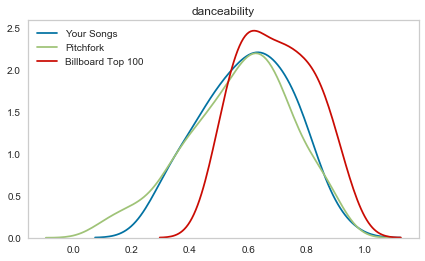

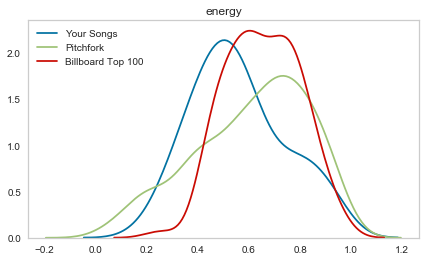

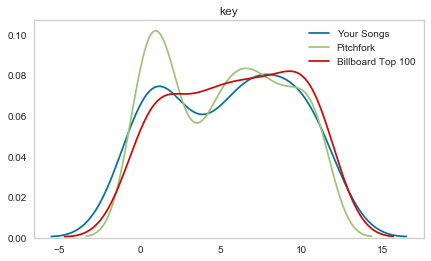

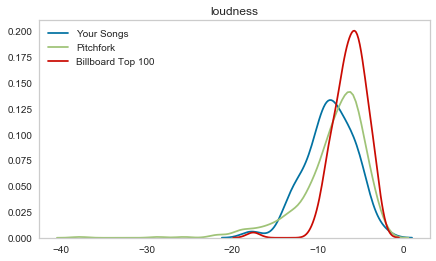

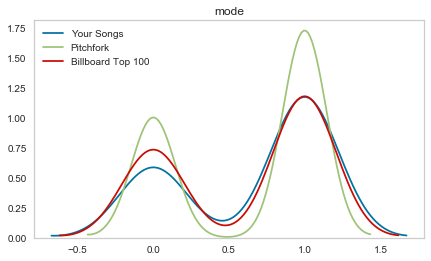

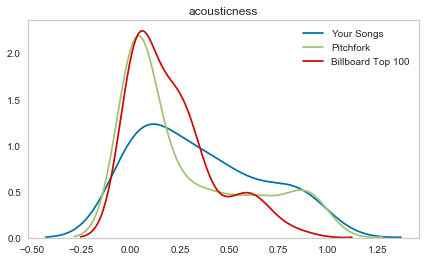

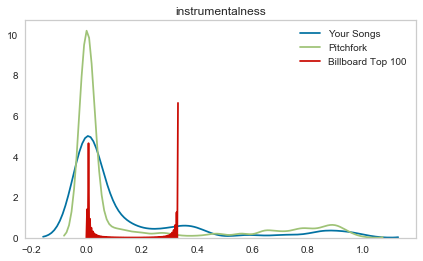

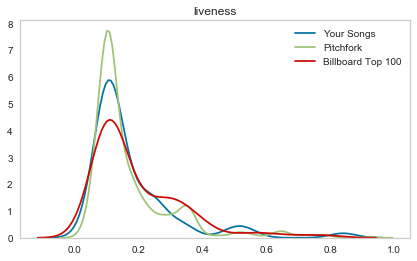

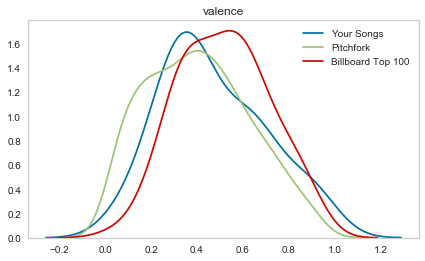

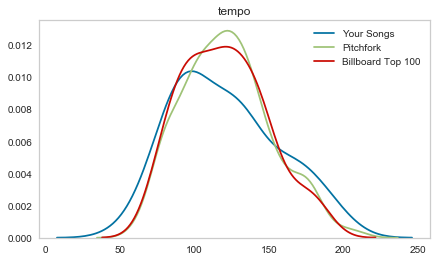

You a Obama?


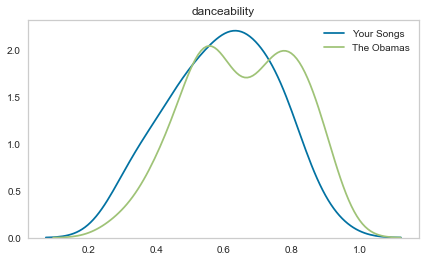

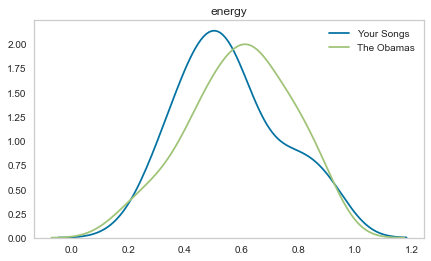

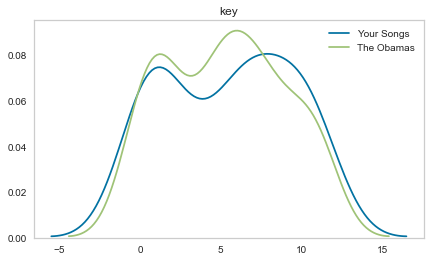

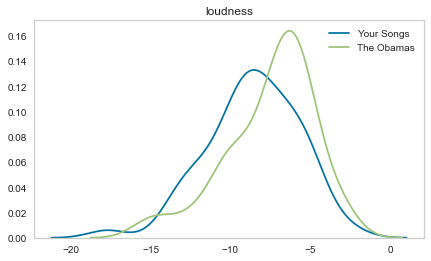

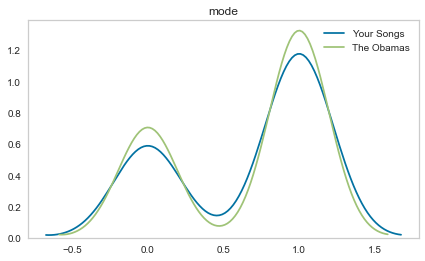

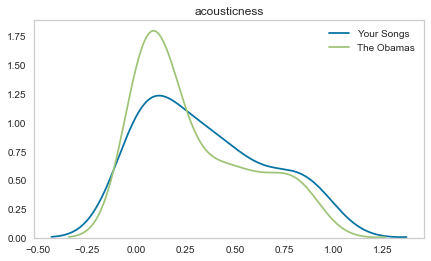

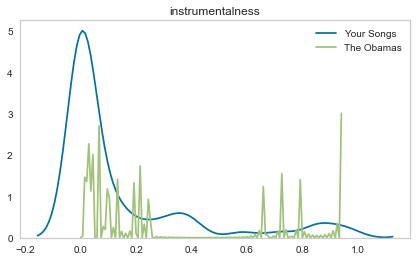

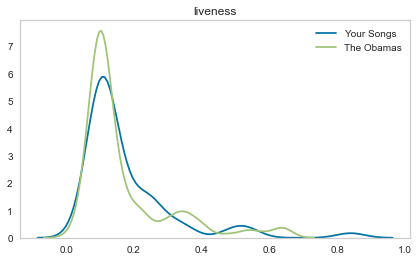

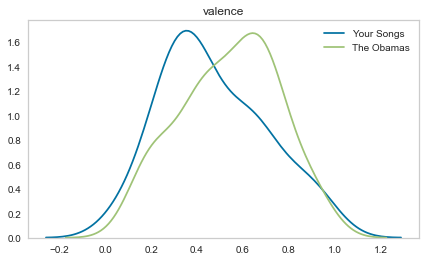

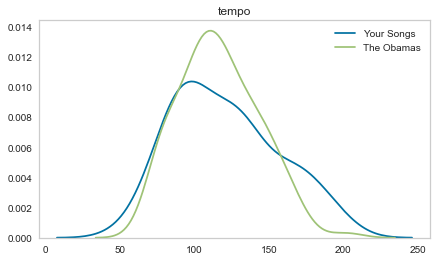

,title,main_artist
144,Morning Sunrise,Weldon Irvine
145,Secret Love,Shayna Steele
297,Breakdown Cover,Barney Artist
391,We've Come So Far,Tom Misch
656,Back to Love,"Evelyn ""Champagne"" King"
803,Everybody Loves The Sunshine - Original Mix,Kan Sano
876,All the Joy,Moonchild
1080,Hood Politics,Kendrick Lamar
1109,Here We Go,Roberta Flack
1278,Soul Sista,Bilal


In [43]:
#input variables
playlist_uri ="2ERd3YQjKnGSEyInrwYPRh"
username = "João Fanha"

mega_function(username, playlist_uri)
